In [6]:
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
from src.models.RandomForestClassifier import RFClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

in this notebook we will train and save a random forest model then plot and show different metrics for the model

In [2]:
RandomForest = RFClassifier()
#load train and test split
X_train = pd.read_csv('../data/processed/train_undersampled.csv')
y_train = X_train['class']
X_train = X_train.drop(['class'], axis=1)
X_test = pd.read_csv('../data/processed/test_reducted.csv')
y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)
#encode labels
label_encoder = LabelEncoder().fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)


We do a grid search to find the best parameters for the model

We run this code in google colab and save the data of the grid searh in a csv file

 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TqehMW7PY5Uu6mqdNrI-QY-2_uj9qFE5?authuser=2#scrollTo=yZtNVPu0hrp-)

In [3]:
#random search for random forest
from scipy.stats import randint as sp_randint
param_dist = {
    'bootstrap': [True],
    'random_state': [0],
    'max_depth': sp_randint(10, 100),
    'max_features': sp_randint(1, 8),
    'min_samples_leaf': sp_randint(1, 10),
    'min_samples_split': sp_randint(5, 20),
    'n_estimators': sp_randint(100, 700),
    'class_weight': [None,'balanced', 'balanced_subsample'],
    'criterion': ['gini'],
    'warm_start': [False],
    'ccp_alpha': [0],
}

RandomForest.hyperparameter_tuning(X_train, y_train, param_dist,'random',3,'f1_macro',10 )

/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does 

load the result from the grid search and plot the results

In [4]:
best_params = RandomForest.best_params
print(best_params)
RandomForest.train(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 58, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 360, 'random_state': 0, 'warm_start': False}


Train the model with the best parameters and save it

Inference time : 2.7350266774495443e-05 seconds
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10802
           1       0.94      0.94      0.94      3429
           2       0.99      1.00      1.00      3769

    accuracy                           0.97     18000
   macro avg       0.97      0.97      0.97     18000
weighted avg       0.97      0.97      0.97     18000

auc score for class 0:  0.9941533035030663
auc score for class 1:  0.9916709262370502
auc score for class 2:  0.9997700079604167


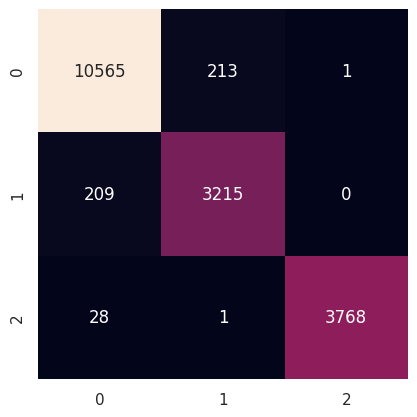

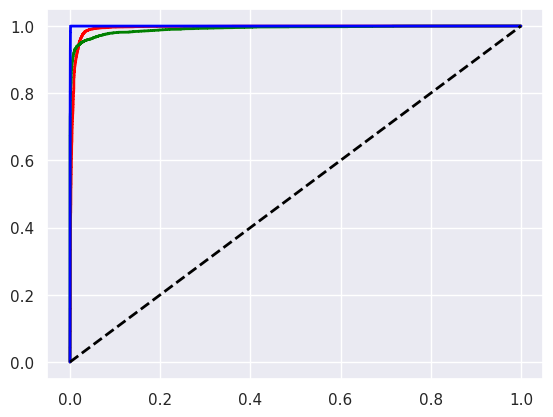

In [9]:
RandomForest.evaluate(X_test, y_test)

Show results of the model, plot the confusion matrix and show the classification report

we try to ameliorate by selecting the best tree to use in the forest

/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does 

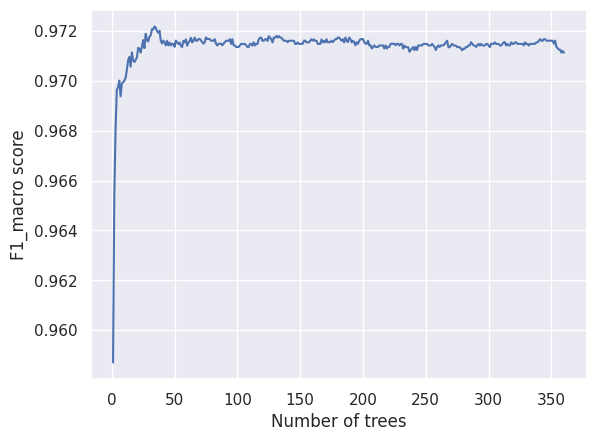

In [10]:
import copy
#calculate the f1_macro score for each tree
f1_macro = []
for estimator in RandomForest.model.estimators_:
    y_pred = estimator.predict(X_test.values)
    f1_macro.append(sk.metrics.f1_score(y_test, y_pred, average='macro'))   
#estimators and f1_macro score in a dataframe
estimators = pd.DataFrame({'estimators': RandomForest.model.estimators_, 'f1_macro': f1_macro})
#arrange estimators by f1_macro score in descending order
estimators = estimators.sort_values(by=['f1_macro'], ascending=False)
#compute the f1 score for the first, the first two, the first three, ... trees
f1_macro_cumul = []
for i in range(1, len(estimators)+1):
    new_model = copy.deepcopy(RandomForest.model)
    new_model.estimators_ = estimators['estimators'].iloc[:i].tolist()
    y_pred = new_model.predict(X_test.values)
    f1_macro_cumul.append(sk.metrics.f1_score(y_test, y_pred, average='macro'))
#plot the f1_macro score for each number of trees
plt.figure()
plt.plot(range(1, len(estimators)+1), f1_macro_cumul)
plt.xlabel('Number of trees')
plt.ylabel('F1_macro score')
plt.show()

In [ ]:
#get the best number of trees
best_n_trees = np.argmax(f1_macro_cumul)+1
new_estimators = estimators['estimators'].iloc[:best_n_trees].tolist()
RandomForest.model.estimators_ = new_estimators

In [ ]:
RandomForest.evaluate(X_test, y_test)